In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import polars as pl
import umap
from LKH import save_EDGE_WEIGHT_SECTION, save_NODE_COORD_SECTION
from pipeline import cluster, filter_redundant_factors, find_lowest_common_ancestor
from plotting import plot_columns, plot_rho_curve, save_matrix
from scipy.cluster.hierarchy import (
    ClusterNode,
    dendrogram,
)
from scipy.spatial.distance import pdist, squareform

In [4]:
RUN_HEAVY = False

In [5]:
YOX1 = "YML027W"
YHP1 = "YDR451C"
CLN3 = "YAL040C"

In [6]:
df_data = pl.read_csv("../data/preprocessed_2090_combined_timeseries.csv", null_values=["NA"])
genes = np.array(df_data.columns)

In [7]:
len(df_data.columns)

5690

In [8]:
df_ccm = pl.read_csv("../data/Cell_Cycle_5690_CCM_all_vs_all.csv", null_values=["NA"]).drop("")
df_ccm.head()

shape: (5, 11)
┌─────┬─────┬─────┬─────┬───┬──────────┬───────────┬───────────┬───────────┐
│ E   ┆ tau ┆ tp  ┆ nn  ┆ … ┆ num_pred ┆ rho       ┆ mae       ┆ rmse      │
│ --- ┆ --- ┆ --- ┆ --- ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ i64 ┆ i64 ┆ i64 ┆ i64 ┆   ┆ i64      ┆ f64       ┆ f64       ┆ f64       │
╞═════╪═════╪═════╪═════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 4   ┆ 3   ┆ 0   ┆ 5   ┆ … ┆ 99       ┆ 0.939771  ┆ 2.248597  ┆ 3.228245  │
│ 4   ┆ 3   ┆ 0   ┆ 5   ┆ … ┆ 99       ┆ 0.939771  ┆ 2.248597  ┆ 3.228245  │
│ 4   ┆ 3   ┆ 0   ┆ 5   ┆ … ┆ 99       ┆ 0.171424  ┆ 0.784599  ┆ 1.19442   │
│ 4   ┆ 3   ┆ 0   ┆ 5   ┆ … ┆ 99       ┆ -0.003084 ┆ 0.443868  ┆ 0.572092  │
│ 4   ┆ 3   ┆ 0   ┆ 5   ┆ … ┆ 99       ┆ -0.119612 ┆ 11.651889 ┆ 32.504013 │
└─────┴─────┴─────┴─────┴───┴──────────┴───────────┴───────────┴───────────┘

In [9]:
df_ccm.select(["E"]).unique()

shape: (6, 1)
┌─────┐
│ E   │
│ --- │
│ i64 │
╞═════╡
│ 6   │
│ 3   │
│ 1   │
│ 4   │
│ 5   │
│ 2   │
└─────┘

In [10]:
if RUN_HEAVY:
    df_ccm.describe()

In [11]:
best_rho = df_ccm.group_by(["lib_column", "target_column"]).agg(pl.max("rho")).sort("lib_column", "target_column")
best_rho

shape: (32_376_100, 3)
┌────────────┬───────────────┬───────────┐
│ lib_column ┆ target_column ┆ rho       │
│ ---        ┆ ---           ┆ ---       │
│ i64        ┆ i64           ┆ f64       │
╞════════════╪═══════════════╪═══════════╡
│ 1          ┆ 1             ┆ 0.939771  │
│ 1          ┆ 2             ┆ 0.939771  │
│ 1          ┆ 3             ┆ 0.171424  │
│ 1          ┆ 4             ┆ -0.003084 │
│ 1          ┆ 5             ┆ -0.119612 │
│ …          ┆ …             ┆ …         │
│ 5690       ┆ 5686          ┆ 0.146628  │
│ 5690       ┆ 5687          ┆ 0.058904  │
│ 5690       ┆ 5688          ┆ -0.00829  │
│ 5690       ┆ 5689          ┆ 0.3969    │
│ 5690       ┆ 5690          ┆ 0.826839  │
└────────────┴───────────────┴───────────┘

In [12]:
N = len(df_ccm.unique(subset="lib_column"))
ccm = best_rho["rho"].to_numpy().reshape((N, N))

N_nan = np.isnan(ccm).sum().sum()
print(f"Number of NaNs: {N_nan}", f"Percentage of NaNs: {N_nan / (N * N) * 100}%")

Number of NaNs: 0 Percentage of NaNs: 0.0%


In [13]:
ccm_clustered, Z_ccm = cluster(ccm, method="average")

if RUN_HEAVY:
    save_matrix(ccm, "../outputs/CCM.png")
    save_matrix(ccm_clustered, "../outputs/CCM_clusterd.png")

In [14]:
corr = df_data.corr().to_numpy()

In [15]:
corr_clustered, Z_corr = cluster(corr, method="average")

if RUN_HEAVY:
    save_matrix(corr, "../outputs/correlation.png")
    save_matrix(corr_clustered, "../outputs/correlation_clustered.png")

In [16]:
rhodiff = ccm - corr

In [17]:
rhodiff_clustered, Z_rhodiff = cluster(rhodiff, method="average")

if RUN_HEAVY:
    save_matrix(rhodiff, "../outputs/rhodiff.png")
    save_matrix(rhodiff_clustered, "../outputs/rhodiff_clustered.png")

In [18]:
target_gene_indecies = np.array(
    [
        np.argwhere(genes == YOX1).squeeze(),
        np.argwhere(genes == YHP1).squeeze(),
        np.argwhere(genes == CLN3).squeeze(),
    ]
)
print(target_gene_indecies)

[3924 1310   66]


In [112]:
def create_link_color_func(
    target_gene_indecies: np.ndarray,
    lca: ClusterNode,
    paths: dict[int, list[int]],
    leaves: np.ndarray,
):
    target_nodes = set()
    subtree_nodes = set()

    for leaf in leaves:
        path = np.array(paths[leaf])
        if leaf in target_gene_indecies:
            target_nodes.add(path[-1])
        subtree_nodes.update(path[path < lca.id])

    subtree_nodes.add(lca.id)

    def link_color_func(i):
        if i in target_nodes:
            return "blue"
        if i in subtree_nodes:
            return "red"
        return "gray"

    return link_color_func


def create_leaf_label_func(target_gene_indecies: np.ndarray):
    def leaf_label_func(i):
        if i in target_gene_indecies:
            return genes[i]
        return None

    return leaf_label_func


if RUN_HEAVY or True:
    for Z, src in [(Z_ccm, "CCM"), (Z_rhodiff, "rhodiff")]:
        for i, by in [(0, "upstream"), (1, "downstream")]:
            lca, paths, leaves = find_lowest_common_ancestor(
                Z[i],
                target_gene_indecies,
            )
            dn = dendrogram(
                Z[i],
                # no_labels=True,
                link_color_func=create_link_color_func(target_gene_indecies, lca, paths, leaves),
                leaf_label_func=create_leaf_label_func(target_gene_indecies),
                leaf_rotation=90,
                leaf_font_size=8,
            )
            plt.title(f"{src} clusterd by {by}")
            plt.tight_layout()
            plt.savefig(f"../outputs/dendrogram_{src}_{by}.png", dpi=300)
            plt.clf()

<Figure size 640x480 with 0 Axes>

In [20]:
lca, paths, leaves = find_lowest_common_ancestor(
    Z_ccm[0],
    target_gene_indecies,
)

In [21]:
ccm_extracted_cluster = ccm[leaves][:, leaves]
ccm_extracted_cluster.shape

(1146, 1146)

In [22]:
filtered_corr, redundancy_mask = filter_redundant_factors(corr, 0.9)
redundant_factors = np.where(~redundancy_mask)[0]
print(len(filtered_corr), len(redundant_factors), redundant_factors)

Filtering redundant factors: 100%|██████████| 5690/5690 [00:00<00:00, 19519.13it/s]


4389 1301 [   1    5    6 ... 5680 5682 5683]


In [23]:
ccm_filtered_redundancy = ccm[redundancy_mask][:, redundancy_mask]
ccm_filtered_redundancy.shape

(4389, 4389)

In [24]:
genes_filtered_redundancy = genes[redundancy_mask]

In [25]:
plot_rho_curve(ccm_filtered_redundancy.flatten())

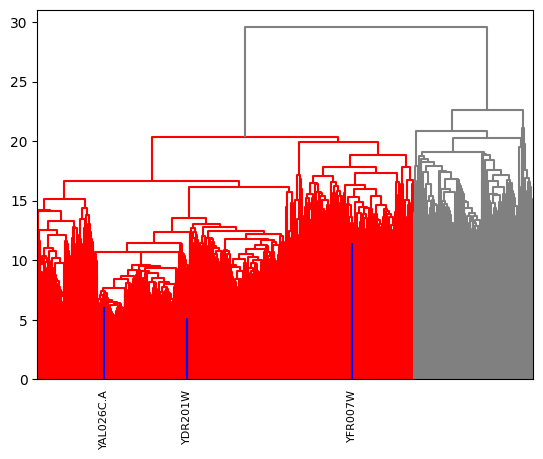

In [26]:
YOX1_Similar = genes[corr[np.argwhere(genes == YOX1).squeeze()] > 0.9]
YOX1_Alternative = YOX1_Similar[np.isin(YOX1_Similar, genes_filtered_redundancy)][0]

target_gene_indecies = np.array(
    [
        np.argwhere(genes_filtered_redundancy == YOX1_Alternative).squeeze(),
        np.argwhere(genes_filtered_redundancy == YHP1).squeeze(),
        np.argwhere(genes_filtered_redundancy == CLN3).squeeze(),
    ]
)

ccm_filtered_redundancy_clustered, Z_ccm_filtered_redundancy = cluster(ccm_filtered_redundancy, method="average")

lca, paths, leaves = find_lowest_common_ancestor(Z_ccm_filtered_redundancy[0], target_gene_indecies)

dn = dendrogram(
    Z_ccm_filtered_redundancy[0],
    # no_labels=True,
    link_color_func=create_link_color_func(target_gene_indecies, lca, paths, leaves),
    leaf_label_func=create_leaf_label_func(target_gene_indecies),
    leaf_rotation=90,
    leaf_font_size=8,
)

In [27]:
ccm_filtered_redundancy_extracted_cluster = ccm_filtered_redundancy[leaves][:, leaves]
ccm_filtered_redundancy_extracted_cluster.shape
# TODO: plot rho curve with other factors

(3336, 3336)

In [28]:
genes_filtered_redundancy_extracted_cluster = genes_filtered_redundancy[leaves]

In [29]:
plot_rho_curve(ccm_filtered_redundancy_extracted_cluster.flatten())

In [30]:
plot_rho_curve(ccm_filtered_redundancy[np.argwhere(genes_filtered_redundancy == CLN3).squeeze()])

In [31]:
plot_rho_curve(
    ccm_filtered_redundancy_extracted_cluster[
        np.argwhere(genes_filtered_redundancy_extracted_cluster == CLN3).squeeze()
    ]
)

In [32]:
pathway = genes_filtered_redundancy_extracted_cluster[
    np.argsort(
        ccm_filtered_redundancy_extracted_cluster[
            np.argwhere(genes_filtered_redundancy_extracted_cluster == CLN3).squeeze()
        ]
    )
]
pathway, YOX1, YHP1, CLN3

(array(['YPR170W.B', 'YDR068W', 'YGR206W', ..., 'YGR279C', 'YLR274W',
        'YGL021W'], dtype='<U9'),
 'YML027W',
 'YDR451C',
 'YAL040C')

In [33]:
np.argwhere(np.isin(pathway, [YOX1_Alternative, YHP1, CLN3]))

array([[1825],
       [3279],
       [3313]])

In [34]:
fit = umap.UMAP()
embedding_of_ccm_filtered_redundancy: np.ndarray = fit.fit_transform(  # type: ignore
    ccm_filtered_redundancy
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [35]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm_filtered_redundancy[:, 0],
        y=embedding_of_ccm_filtered_redundancy[:, 1],
        mode="markers",
        marker=dict(
            color=["red" if gene in [YOX1_Alternative, YHP1, CLN3] else "blue" for gene in genes_filtered_redundancy],
            size=[8 if gene in [YOX1_Alternative, YHP1, CLN3] else 5 for gene in genes_filtered_redundancy],
        ),
        text=genes_filtered_redundancy,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [36]:
plot_columns(df_data, YOX1_Similar)  # type: ignore

In [37]:
fit = umap.UMAP()
embedding_of_ccm: np.ndarray = fit.fit_transform(ccm)  # type: ignore

In [38]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=["red" if gene in [YOX1, YHP1, CLN3] else "blue" for gene in genes],
            size=[8 if gene in [YOX1, YHP1, CLN3] else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [39]:
upstream_similarity = np.corrcoef(ccm)
np.isin(
    [YOX1, YHP1],
    genes[np.argsort(upstream_similarity[np.argwhere(genes == CLN3).squeeze()])][-100:],
)

array([False, False])

In [40]:
center = embedding_of_ccm[np.argwhere(genes == CLN3).squeeze()]
mask = squareform(pdist(embedding_of_ccm - center))[np.argwhere(genes == CLN3).squeeze()] < 1

genes_extracted_umap_cluster = genes[mask]

In [41]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                "green" if gene in [YOX1, YHP1, CLN3] else "red" if gene in genes_extracted_umap_cluster else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [42]:
filtered_corr_extracted_umap_cluster, redundancy_mask_extracted_umap_cluster = filter_redundant_factors(
    corr[mask][:, mask], 0.9
)

Filtering redundant factors: 100%|██████████| 196/196 [00:00<00:00, 118643.90it/s]


In [92]:
ccm_umap_cluster_filtered = ccm[mask][:, mask][redundancy_mask_extracted_umap_cluster][
    :, redundancy_mask_extracted_umap_cluster
]
embedding_of_ccm_umap_cluster_filtered = embedding_of_ccm[mask][redundancy_mask_extracted_umap_cluster]
genes_extracted_umap_cluster_filtered = genes_extracted_umap_cluster[redundancy_mask_extracted_umap_cluster]

save_EDGE_WEIGHT_SECTION(
    ccm_umap_cluster_filtered,
    "../outputs/EDGE_WEIGHT_SECTION2txt",
)
save_NODE_COORD_SECTION(embedding_of_ccm_umap_cluster_filtered * 100, "../outputs/NODE_COORD_SECTION2.txt")

In [44]:
layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                # "green"
                # if gene in [YOX1, YHP1, CLN3]
                # else "red"
                "red" if gene in genes_extracted_umap_cluster_filtered else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [72]:
with open("../LKH-3.0.10/gene2.tour", "r") as f:
    for line in f:
        if line.startswith("TOUR_SECTION"):
            break
    tour = np.array([int(line) - 1 for line in f.readlines()[:-2]])

layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                "green"
                if gene in [YOX1, YHP1, CLN3]
                else "red"
                if gene in genes_extracted_umap_cluster_filtered
                else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    ),
    # add lines for tour (tour include order within genes_extracted_umap_cluster[redundancy_mask_extracted_umap_cluster])
    go.Scatter(
        x=embedding_of_ccm_umap_cluster_filtered[tour, 0],
        y=embedding_of_ccm_umap_cluster_filtered[tour, 1],
    ),
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [48]:
genes_extracted_umap_cluster[redundancy_mask_extracted_umap_cluster][tour]

array(['YAL040C', 'YBR218C', 'YER016W', 'YIL132C', 'YBL002W', 'YCR034W',
       'YDR451C', 'YBL082C', 'YGL032C', 'YHR204W', 'YAL034W.A', 'YDR183W',
       'YAR003W', 'YLR386W', 'YEL047C', 'YKR042W', 'YGR205W', 'YPL092W',
       'YPL106C', 'YGR153W', 'YJL113W', 'YGL061C', 'YLR273C', 'YKL092C',
       'YPL208W', 'YOR028C', 'YHR092C', 'YIL121W', 'YDL197C', 'YDR348C',
       'YAR007C', 'YGL194C.A', 'YDL102W', 'YDR279W', 'YDL055C', 'YOR342C',
       'YNL197C', 'YOR238W', 'YFR046C', 'YKL008C', 'YOR368W', 'YNL298W',
       'YKR090W', 'YNR034W.A', 'YBR073W', 'YDL042C', 'YAL031C',
       'YBL071W.A', 'YNL104C', 'YJL194W', 'YJR031C', 'YMR232W', 'YOL011W',
       'YOR034C', 'YEL017W', 'YBL069W', 'YJR118C', 'YJR057W', 'YMR094W',
       'YLR182W', 'YOR378W', 'YPL194W', 'YIL056W', 'YPL122C', 'YNL309W',
       'YBL034C', 'YDR013W', 'YAL007C', 'YDR331W', 'YDR385W', 'YCL027W',
       'YMR296C', 'YGL002W', 'YGL116W', 'YJL153C', 'YEL001C', 'YJL116C',
       'YDL010W', 'YHR127W', 'YHR050W', 'YDR414C', 'YE

In [73]:
with open("../LKH-3.0.10/umap2.tour", "r") as f:
    for line in f:
        if line.startswith("TOUR_SECTION"):
            break
    tour = np.array([int(line) - 1 for line in f.readlines()[:-2]])

layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding_of_ccm[:, 0],
        y=embedding_of_ccm[:, 1],
        mode="markers",
        marker=dict(
            color=[
                "green"
                if gene in [YOX1, YHP1, CLN3]
                else "red"
                if gene in genes_extracted_umap_cluster_filtered
                else "blue"
                for gene in genes
            ],
            size=[8 if gene in genes_extracted_umap_cluster else 5 for gene in genes],
        ),
        text=genes,
        hoverinfo="text",
    ),
    # add lines for tour (tour include order within genes_extracted_umap_cluster[redundancy_mask_extracted_umap_cluster])
    go.Scatter(
        x=embedding_of_ccm_umap_cluster_filtered[tour, 0],
        y=embedding_of_ccm_umap_cluster_filtered[tour, 1],
    ),
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [65]:
np.argwhere(genes_extracted_umap_cluster_filtered == CLN3).squeeze()

array(4)

In [104]:
from networkx.algorithms.tree.branchings import Edmonds

G: nx.DiGraph = nx.from_numpy_array(ccm_umap_cluster_filtered, create_using=nx.DiGraph)
E = Edmonds(G)

MST = E.find_optimum(kind="max")

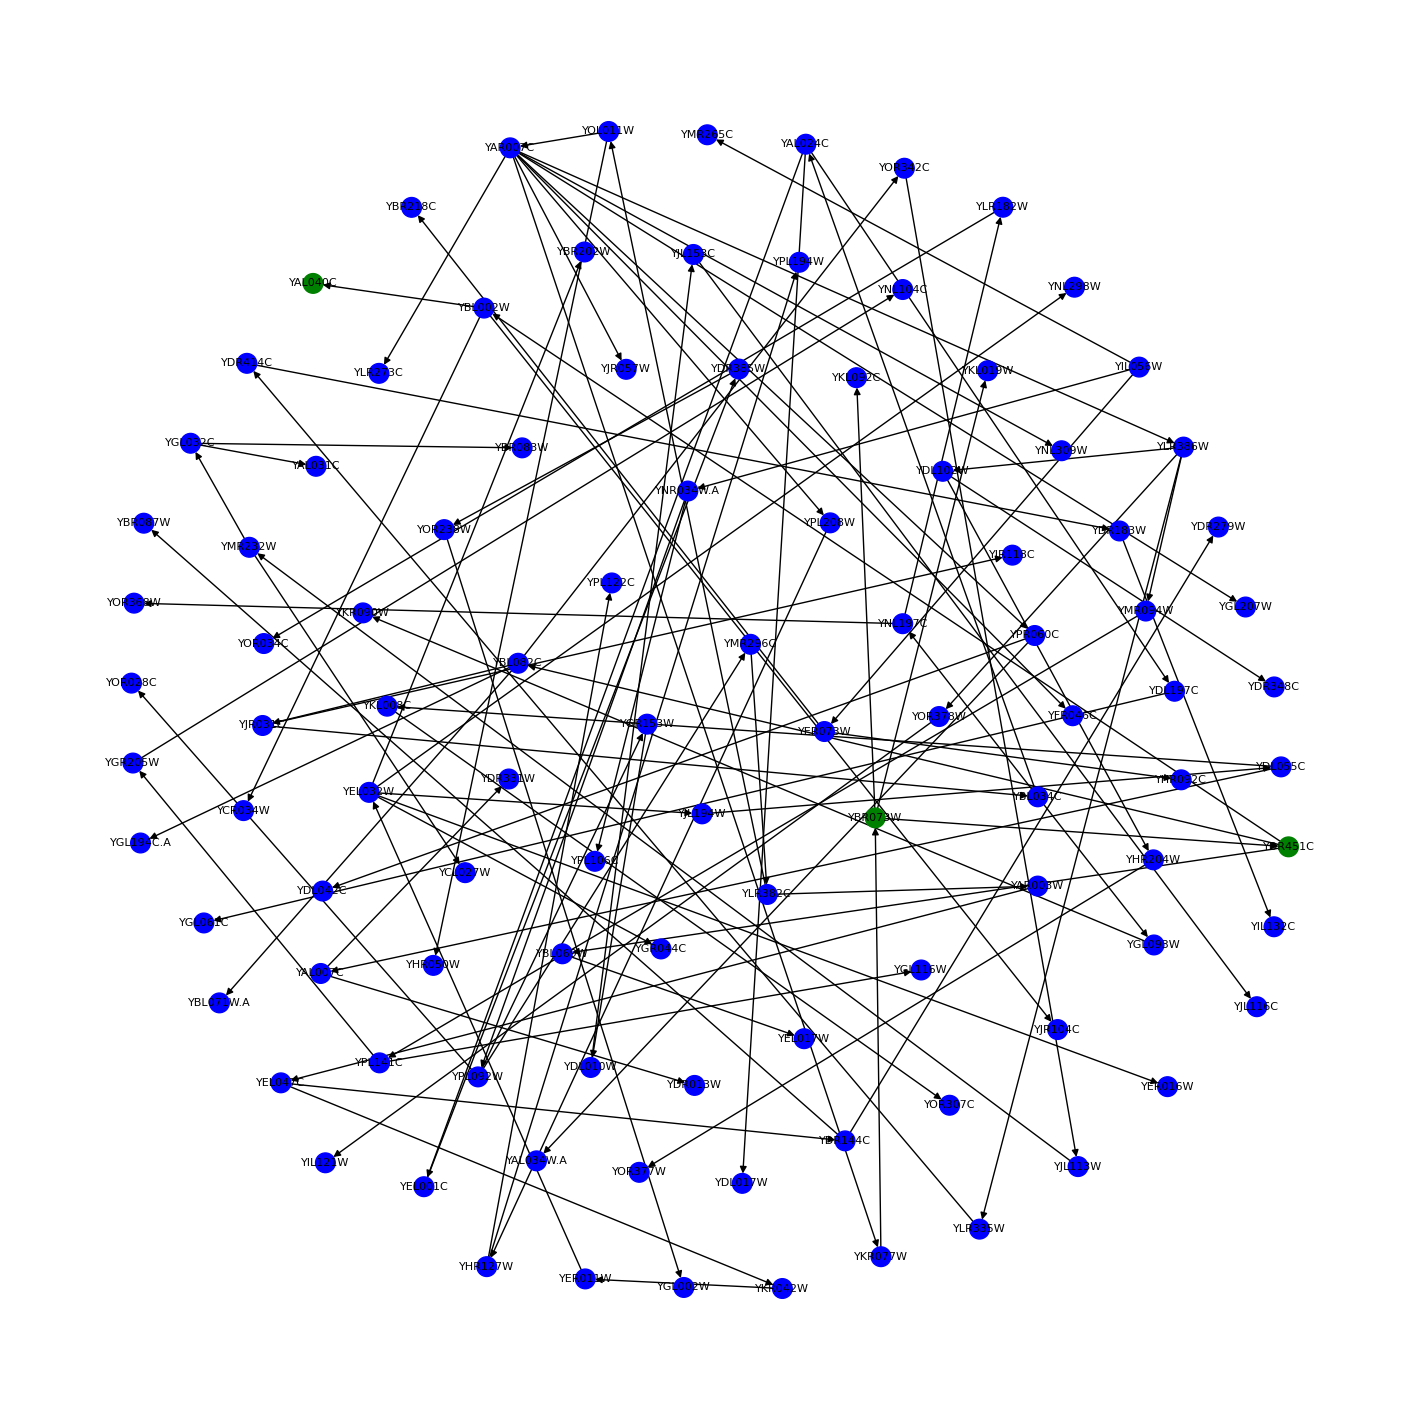

In [111]:
plt.figure(figsize=(14, 14))
nx.draw(
    MST,
    pos=nx.nx_agraph.graphviz_layout(G, prog="fdp"),
    labels=dict(enumerate(genes_extracted_umap_cluster_filtered)),
    node_color=[
        "green" if gene in [YOX1, YHP1, CLN3] + YOX1_Similar.tolist() else "blue"
        for gene in genes_extracted_umap_cluster_filtered
    ],
    node_size=200,
    font_size=8,
)

In [51]:
from edmkit.tensor import Tensor, dtypes


def MarkovCluster(A: Tensor, e: int = 2, r: float = 2.0, max_iter: int = 100, tol: float = 1e-5) -> Tensor:
    n = A.shape[0]
    # A = A + Tensor.eye(n)
    M = A / A.sum(axis=0)
    for _ in range(max_iter):
        # M_prev = M
        # expansion step
        for _ in range(e):
            M = M @ M
        # inflation step
        M = M**r
        # normalization step
        M = M / M.sum(axis=0)
        # check convergence
        # if (M - M_prev).abs().max().numpy() < tol:
        #     break
    return M


def find_clusters(M: np.ndarray, threshold: float = 0.9) -> list[tuple[int, ...]]:
    n = M.shape[0]
    clusters = []
    # クラスタの抽出
    for i in range(n):
        cluster = tuple(np.where(M[i] > threshold)[0])
        if cluster and cluster not in clusters:
            clusters.append(cluster)
    return clusters


A = Tensor(rhodiff, dtype=dtypes.float32)
print(A.shape)
M = MarkovCluster(A).numpy()
clusters = find_clusters(M)

Running on macOS, setting METAL_XCODE=1 and DISABLE_COMPILER_CACHE=1
(5690, 5690)


RuntimeError: Error Domain=MTLCommandBufferErrorDomain Code=2 "Caused GPU Timeout Error (00000002:kIOAccelCommandBufferCallbackErrorTimeout)" UserInfo={NSLocalizedDescription=Caused GPU Timeout Error (00000002:kIOAccelCommandBufferCallbackErrorTimeout)}